In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from lime import lime_tabular
import shap
import pickle

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, 
                       message="X does not have valid feature names*")

# Load Saved Model

In [7]:
def load_model(filename):
    """Load the trained model from disk"""
    with open(filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return loaded_model


# Load Traing and test data

In [9]:
def load_data(filename='data.pkl'):
    """Load DataFrame from disk"""
    with open(filename, 'rb') as file:
        loaded_data = pickle.load(file)
    print(f"Data loaded from {filename}")
    return loaded_data



In [11]:
adhd_model = load_model('adhd_rf_model.pkl')
final_test = load_data('final_test_data.pkl')
X_test = load_data('X_test_data.pkl')
y_test_adhd = load_data('y_test_adhd_data.pkl')

Model loaded from adhd_rf_model.pkl
Data loaded from final_test_data.pkl
Data loaded from X_test_data.pkl
Data loaded from y_test_adhd_data.pkl


# Data Type and Format Standardization

In [13]:
if isinstance(X_test, pd.Series):
    X_test = X_test.values
    # If X_test is a Pandas Series, convert it to a NumPy array.
elif not isinstance(X_test, (pd.DataFrame, np.ndarray)):
    X_test = np.array(X_test)

# to make sure y_test_adhd is a numpy array of integers
if isinstance(y_test_adhd, pd.Series):
    y_test_adhd = y_test_adhd.values
y_test_adhd = np.array(y_test_adhd).astype(int)

# Check the data after loading
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")
print(f"y_test_adhd type: {type(y_test_adhd)}, shape: {y_test_adhd.shape}, values: {np.unique(y_test_adhd)}")

X_test type: <class 'pandas.core.frame.DataFrame'>, shape: (243, 623)
y_test_adhd type: <class 'numpy.ndarray'>, shape: (243,), values: [0 1]


# Predicting ADHD using Random forest


Evaluating Random forest ADHD model performance...
Overall Performance:
Accuracy: 0.7778
Precision: 0.8087
Recall: 0.8862
F1 Score: 0.8457


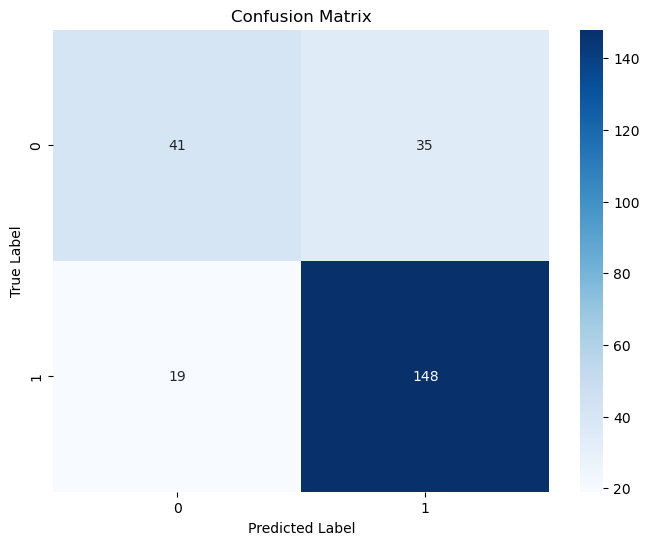


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        76
           1       0.81      0.89      0.85       167

    accuracy                           0.78       243
   macro avg       0.75      0.71      0.72       243
weighted avg       0.77      0.78      0.77       243


Gender-Specific Performance:
Male F1 Score: 0.8525
Female F1 Score: 0.8302
Gender Disparity (F1 difference): 0.0223


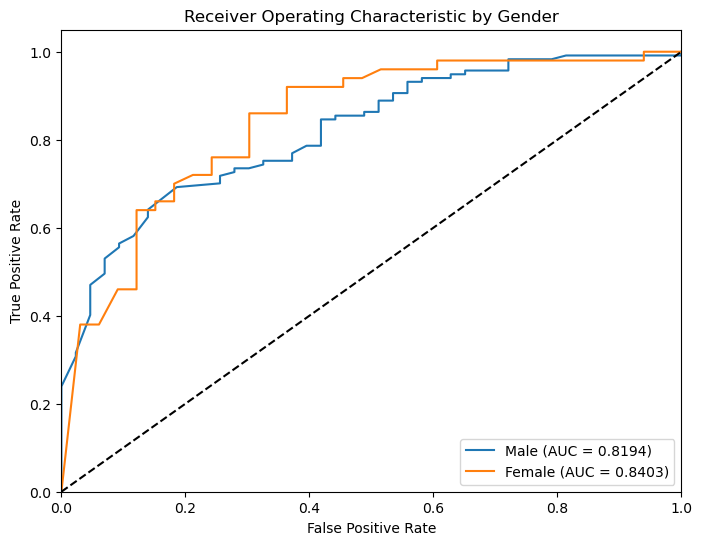

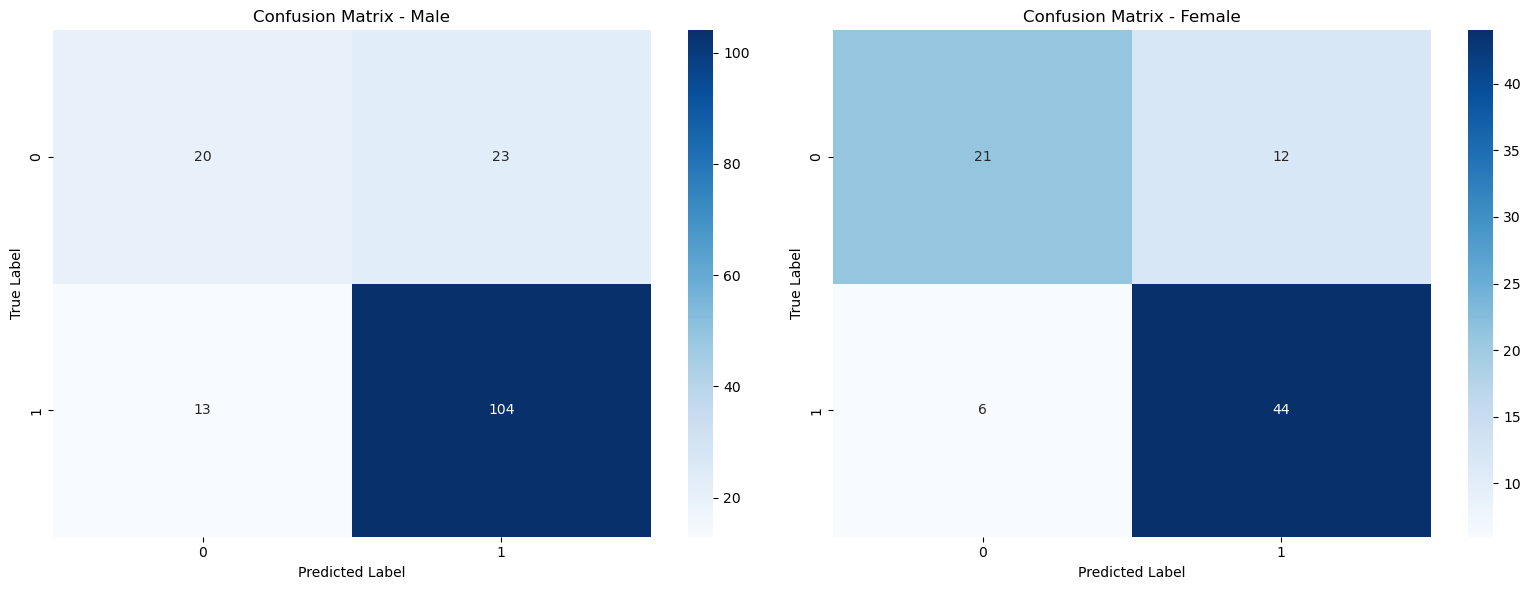

In [15]:
def evaluate_adhd_model(model, X_test, y_test, metadata_test):
    
    # Overall performance
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Overall Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Gender-specific performance to understand bias
    gender_col = 'Sex_F'  
    
    
    gender = metadata_test[gender_col].values
    
    
    male_idx = gender == 0
    y_male = y_test[male_idx]
    y_pred_male = y_pred[male_idx]
    
    
    female_idx = gender == 1
    y_female = y_test[female_idx]
    y_pred_female = y_pred[female_idx]
    
    male_f1 = f1_score(y_male, y_pred_male)
    female_f1 = f1_score(y_female, y_pred_female)
    
    print("\nGender-Specific Performance:")
    print(f"Male F1 Score: {male_f1:.4f}")
    print(f"Female F1 Score: {female_f1:.4f}")
    print(f"Gender Disparity (F1 difference): {abs(male_f1 - female_f1):.4f}")
    
    # Calculate ROC curve and AUC for each gender
    male_probs = model.predict_proba(X_test[male_idx])[:, 1]
    female_probs = model.predict_proba(X_test[female_idx])[:, 1]
    
    male_fpr, male_tpr, _ = roc_curve(y_male, male_probs)
    female_fpr, female_tpr, _ = roc_curve(y_female, female_probs)
    
    male_auc = auc(male_fpr, male_tpr)
    female_auc = auc(female_fpr, female_tpr)
    
    # Plot ROC curves by gender
    plt.figure(figsize=(8, 6))
    plt.plot(male_fpr, male_tpr, label=f'Male (AUC = {male_auc:.4f})')
    plt.plot(female_fpr, female_tpr, label=f'Female (AUC = {female_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic by Gender')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate confusion matrices by gender
    male_cm = confusion_matrix(y_male, y_pred_male)
    female_cm = confusion_matrix(y_female, y_pred_female)
    
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(male_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix - Male')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    sns.heatmap(female_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix - Female')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Store results
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'male_f1': male_f1,
        'female_f1': female_f1,
        'gender_disparity': abs(male_f1 - female_f1),
        'male_auc': male_auc,
        'female_auc': female_auc
    }
    
    return results


print("\nEvaluating Random forest ADHD model performance...")
adhd_results = evaluate_adhd_model(adhd_model, X_test, y_test_adhd, final_test)


In [17]:
with open('gender_rf_model.pkl', 'rb') as file:
    gender_model = pickle.load(file)
print("Gender prediction model loaded successfully")

Gender prediction model loaded successfully


In [19]:
with open('y_test_sex.pkl', 'rb') as file:
    y_test_sex = pickle.load(file)
print("Gender test data loaded successfully")

Gender test data loaded successfully


In [21]:
if isinstance(y_test_sex, pd.Series):
    y_test_sex = y_test_sex.values
y_test_sex = np.array(y_test_sex).astype(int)

# Evaluate Models

Finding optimal threshold based on F1 score...
Optimal threshold: 0.30, F1: 0.5408

Gender Prediction Performance(Random Forest) (optimal threshold = 0.30):
Accuracy: 0.5597
Precision: 0.4200
Recall: 0.7590
F1 Score: 0.5408


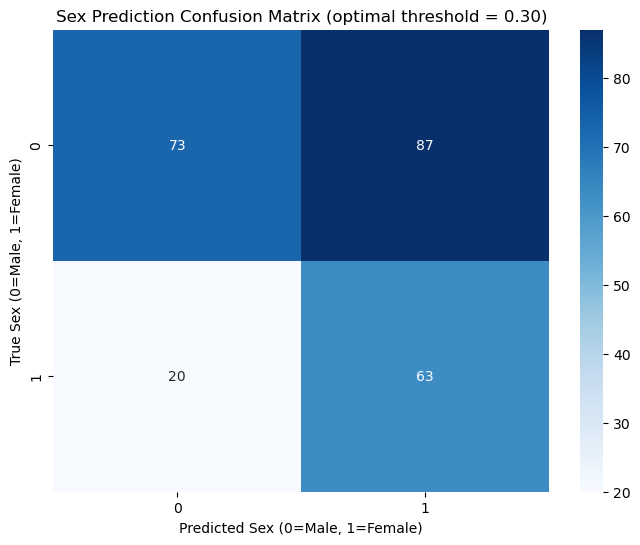


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       160
           1       0.42      0.76      0.54        83

    accuracy                           0.56       243
   macro avg       0.60      0.61      0.56       243
weighted avg       0.66      0.56      0.56       243



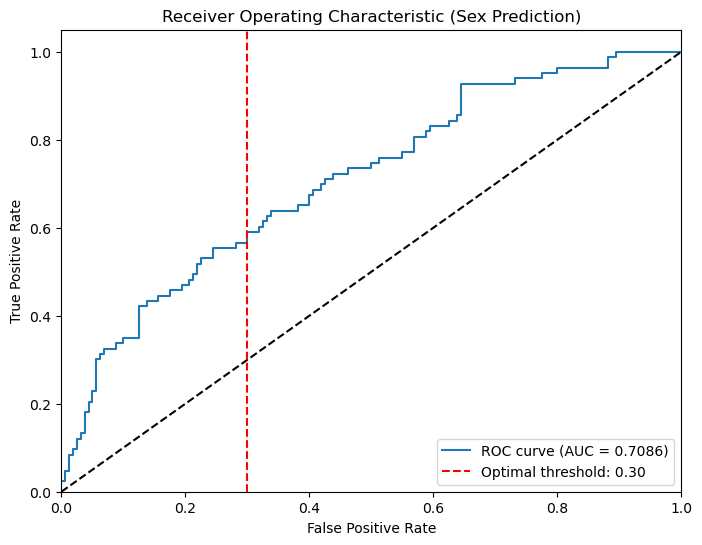

In [54]:
def evaluate_gender_model(model, X_test, y_test):
    
    
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    print("Finding optimal threshold based on F1 score...")
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred_t = (y_probs >= threshold).astype(int)
        try:
            f1_t = f1_score(y_test, y_pred_t)
            if f1_t > best_f1:
                best_f1 = f1_t
                best_threshold = threshold
        except:
            continue
    
    print(f"Optimal threshold: {best_threshold:.2f}, F1: {best_f1:.4f}")
    
    
    y_pred = (y_probs >= best_threshold).astype(int)
    
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
   
    print(f"\nGender Prediction Performance(Random Forest) (optimal threshold = {best_threshold:.2f}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Sex Prediction Confusion Matrix (optimal threshold = {best_threshold:.2f})')
    plt.ylabel('True Sex (0=Male, 1=Female)')
    plt.xlabel('Predicted Sex (0=Male, 1=Female)')
    plt.show()
    
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axvline(x=best_threshold, color='r', linestyle='--', 
                label=f'Optimal threshold: {best_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Sex Prediction)')
    plt.legend(loc="lower right")
    plt.show()
    
   
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'best_threshold': best_threshold,
        'confusion_matrix': cm
    }
    
    return results


gender_results = evaluate_gender_model(gender_model, X_test, y_test_sex)

In [27]:
adhd_svm_model = load_model('adhd_svm_model.pkl')
    
gender_svm_model = load_model('gender_svm_model.pkl')

Model loaded from adhd_svm_model.pkl
Model loaded from gender_svm_model.pkl


In [29]:
if isinstance(X_test, pd.Series) or isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
if isinstance(y_test_adhd, pd.Series):
        y_test_adhd = y_test_adhd.values
if isinstance(y_test_sex, pd.Series):
        y_test_sex = y_test_sex.values

# Evaluating SVM Models

ADHD SVM Model
Overall Performance:
Accuracy: 0.7572
Precision: 0.7784
Recall: 0.9042
F1 Score: 0.8366


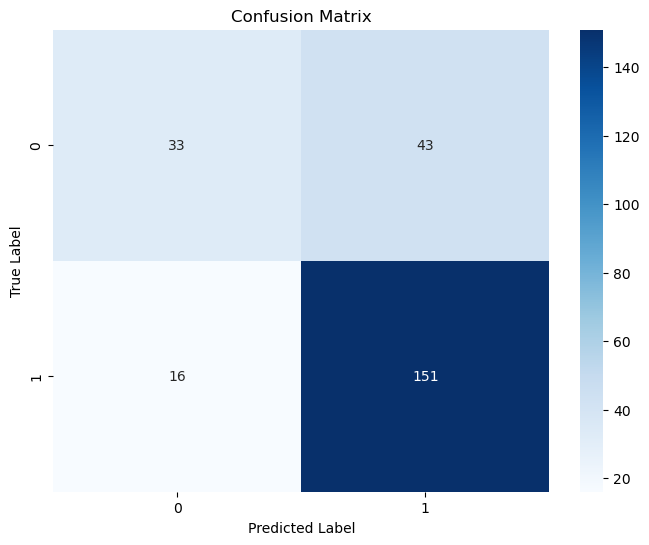


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.43      0.53        76
           1       0.78      0.90      0.84       167

    accuracy                           0.76       243
   macro avg       0.73      0.67      0.68       243
weighted avg       0.75      0.76      0.74       243


Gender-Specific Performance:
Male F1 Score: 0.8548
Female F1 Score: 0.7965
Gender Disparity (F1 difference): 0.0584


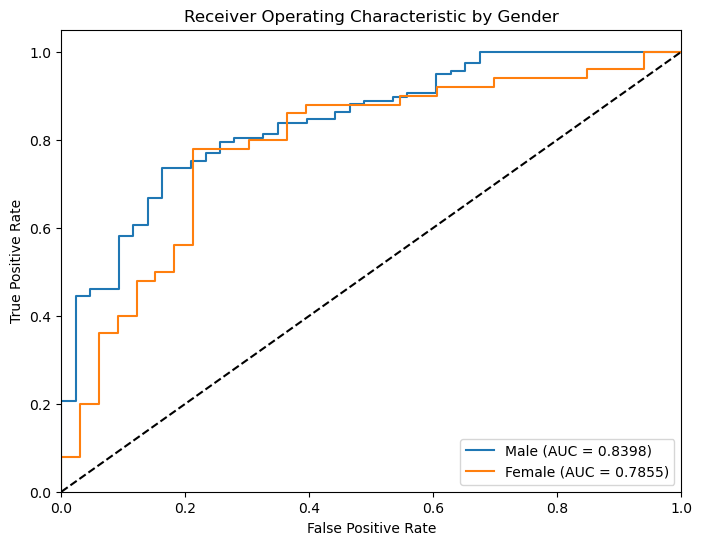

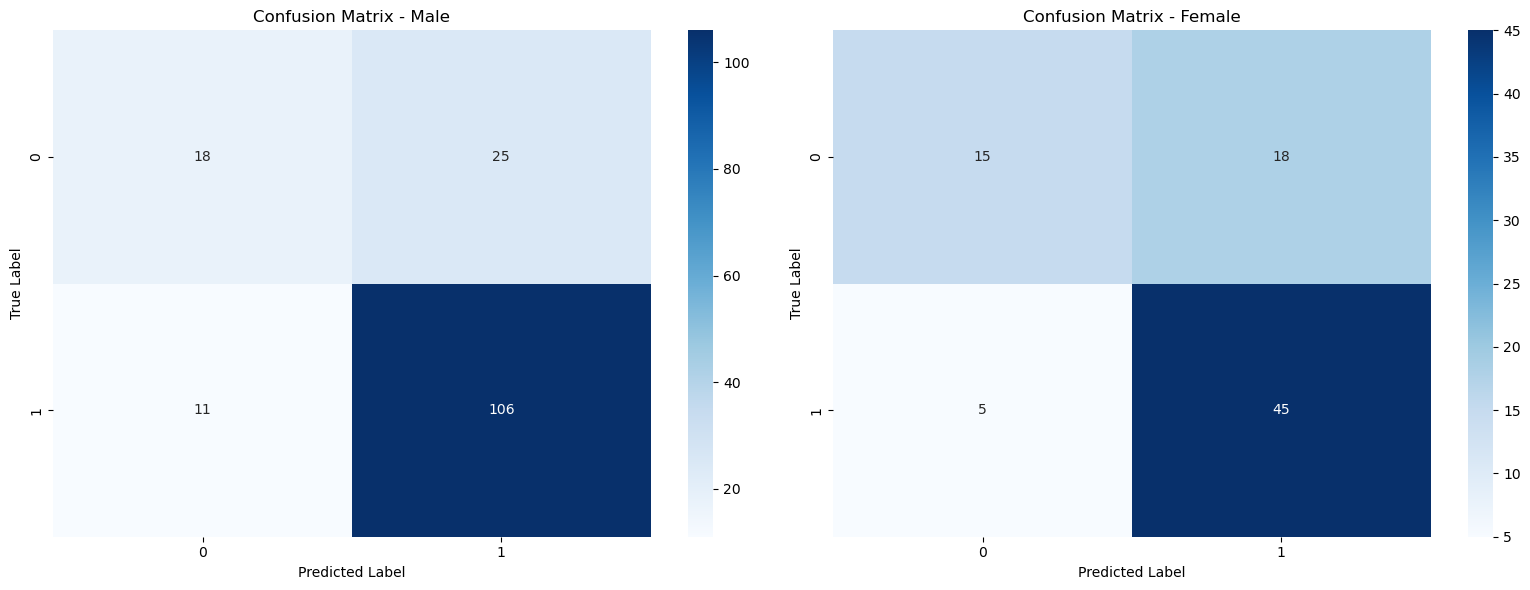

In [31]:
print("ADHD SVM Model")
adhd_svm_results = evaluate_adhd_model(adhd_svm_model, X_test, y_test_adhd, final_test)

Gender SVM model
Finding optimal threshold based on F1 score...
Optimal threshold: 0.25, F1: 0.5556

Gender Prediction Performance(Random Forest) (optimal threshold = 0.25):
Accuracy: 0.5062
Precision: 0.4011
Recall: 0.9036
F1 Score: 0.5556


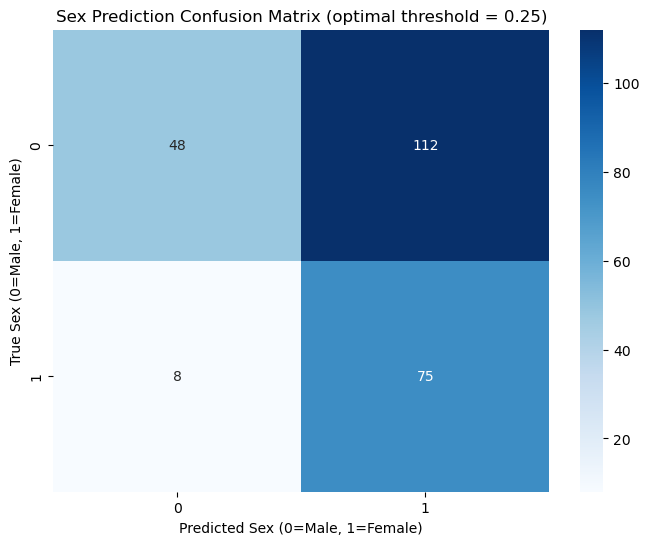


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.30      0.44       160
           1       0.40      0.90      0.56        83

    accuracy                           0.51       243
   macro avg       0.63      0.60      0.50       243
weighted avg       0.70      0.51      0.48       243



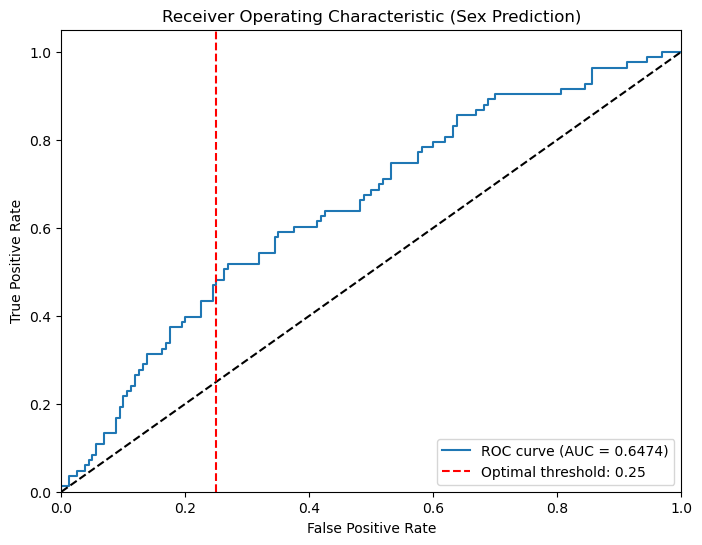

In [33]:
print("Gender SVM model")
gender_svm_results = evaluate_gender_model(gender_svm_model, X_test, y_test_sex)

# Comparing Model Performance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the NHS color palette
nhs_blue = "#005EB8"
nhs_dark_blue = "#003087" 
nhs_teal = "#00A9CE"
nhs_green = "#78BE20"
nhs_orange = "#F9A926"

# ADHD MODEL DATA from your classification reports
# Random Forest model
rf_accuracy = 0.7778 * 100
rf_precision = 0.8087 * 100
rf_recall = 0.8862 * 100
rf_f1 = 0.8457 * 100
rf_male_f1 = 0.8525 * 100
rf_female_f1 = 0.8302 * 100
rf_disparity = 0.0223 * 100

# SVM model
svm_accuracy = 0.7572 * 100
svm_precision = 0.7784 * 100
svm_recall = 0.9042 * 100
svm_f1 = 0.8366 * 100
svm_male_f1 = 0.8548 * 100
svm_female_f1 = 0.7965 * 100
svm_disparity = 0.0584 * 100

# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)

# PLOT 1: Overall Model Performance Comparison
metrics = ['Accuracy', 'F1 Score']
rf_values = [rf_accuracy, rf_f1]
svm_values = [svm_accuracy, svm_f1]

x = np.arange(len(metrics))
width = 0.35

# Create the bar chart for overall metrics
rects1 = ax1.bar(x - width/2, rf_values, width, label='Random Forest', color=nhs_blue)
rects2 = ax1.bar(x + width/2, svm_values, width, label='SVM', color=nhs_teal)

# Add data labels on top of bars
for rect in rects1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
            
for rect in rects2:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax1.set_ylim(70, 90)  # Set y-axis to start at 70 for better visual comparison
ax1.set_ylabel('Performance (%)', fontsize=12)
ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend(loc='lower right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# PLOT 2: Gender Performance Comparison
x = np.arange(2)  # the label locations
width = 0.35  # the width of the bars

# Create grouped bars for gender-specific performance
rects1 = ax2.bar(x - width/2, [rf_male_f1, rf_female_f1], width, label='Random Forest', color=nhs_blue)
rects2 = ax2.bar(x + width/2, [svm_male_f1, svm_female_f1], width, label='SVM', color=nhs_teal)

# Add data labels on top of bars
for rect in rects1:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
            
for rect in rects2:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax2.set_ylim(75, 90)  # Focus on the performance range
ax2.set_ylabel('F1 Score (%)', fontsize=12)
ax2.set_title('Gender-Specific Performance', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Male', 'Female'])
ax2.legend(loc='lower right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_axisbelow(True)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotations highlighting the gap
ax2.annotate(f'Gap: {rf_disparity:.1f}%', 
             xy=(0, rf_female_f1 - 0.7), xytext=(0, rf_female_f1 - 2.5),
             ha='center', va='bottom', color='black', fontsize=9)

ax2.annotate(f'Gap: {svm_disparity:.1f}%', 
             xy=(1, svm_female_f1 - 0.7), xytext=(1, svm_female_f1 - 2.5),
             ha='center', va='bottom', color='black', fontsize=9)

# Add a subtle highlight to show the gaps
ax2.annotate('', xy=(0-width/2, rf_male_f1), xytext=(0-width/2, rf_female_f1),
             arrowprops=dict(arrowstyle='<->', color=nhs_orange, lw=2, ls='--'))
             
ax2.annotate('', xy=(1+width/2, svm_male_f1), xytext=(1+width/2, svm_female_f1),
             arrowprops=dict(arrowstyle='<->', color=nhs_orange, lw=2, ls='--'))

# Add overall title explaining the charts
plt.suptitle('Initial Model Performance and Gender Bias Detection', fontsize=16, fontweight='bold', y=0.98)

# Add explanatory caption at the bottom
fig.text(0.5, 0.01, 
         "Both models show gender disparity, with SVM showing higher bias (5.8%) compared to Random Forest (2.2%)",
         ha='center', fontsize=11, style='italic')

# Adjust layout and save
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('model_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a third figure specifically highlighting the gender disparity
plt.figure(figsize=(8, 6))

# Data for the disparity chart
models = ['Random Forest', 'SVM']
disparities = [rf_disparity, svm_disparity]  # Already in percentages
colors = [nhs_blue, nhs_teal]

# Create the bar chart
bars = plt.bar(models, disparities, color=colors, width=0.6)

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Add a visual reference line for "acceptable" disparity
plt.axhline(y=2.0, color=nhs_green, linestyle='--', alpha=0.7, 
            label='Target maximum disparity (2%)')

# Customize the plot
plt.ylabel('Gender Performance Gap (%)', fontsize=12)
plt.title('Gender Bias Comparison Between Models', fontsize=14, fontweight='bold')
plt.ylim(0, 7)
plt.legend()

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Save the figure
plt.tight_layout()
plt.savefig('gender_disparity_chart.png', dpi=300, bbox_inches='tight')
plt.show()